# [**Discrétisation des caractéristiques**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/6_3_preprocessing/plot_discretization_classification.ipynb)<br/>([_Feature discretization_](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization_classification.html))

Une démonstration de la discrétisation des caractéristiques sur des jeux de données de classification synthétiques. La discrétisation des caractéristiques décompose chaque caractéristique en un ensemble d'intervalles, ici répartis de manière équidistante. Les valeurs discrètes sont ensuite encodées en "one-hot" et fournies à un classifieur linéaire. Ce prétraitement permet un comportement non linéaire même si le classifieur est linéaire.

Dans cet exemple, les deux premières rangées représentent des jeux de données linéairement non séparables (des lunes et des cercles concentriques) tandis que la troisième est approximativement linéairement séparable. Sur les deux jeux de données linéairement non séparables, la discrétisation des caractéristiques améliore considérablement les performances des classifieurs linéaires. Sur le jeu de données linéairement séparable, la discrétisation des caractéristiques diminue les performances des classifieurs linéaires. Deux classifieurs non linéaires sont également présentés à des fins de comparaison.

Cet exemple doit être pris avec prudence, car l'intuition qui en est tirée ne se traduit pas nécessairement dans les jeux de données réels. En particulier dans les espaces de grande dimension, les données peuvent plus facilement être séparées linéairement. De plus, l'utilisation de la discrétisation des caractéristiques et de l'encodage en "one-hot" augmente le nombre de caractéristiques, ce qui peut entraîner facilement un surajustement lorsque le nombre d'échantillons est faible.

Les graphiques montrent les points d'entraînement en couleurs pleines et les points de test en semi-transparence. En bas à droite, on montre la précision de classification sur l'ensemble de test.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_discretization_classification_001.png)


dataset 0
---------
LogisticRegression: 0.86
LinearSVC: 0.86
KBinsDiscretizer + LogisticRegression: 0.86
KBinsDiscretizer + LinearSVC: 0.94
GradientBoostingClassifier: 0.90
SVC: 0.94

dataset 1
---------
LogisticRegression: 0.40
LinearSVC: 0.40
KBinsDiscretizer + LogisticRegression: 0.78
KBinsDiscretizer + LinearSVC: 0.80
GradientBoostingClassifier: 0.84
SVC: 0.84

dataset 2
---------
LogisticRegression: 0.98
LinearSVC: 0.96
KBinsDiscretizer + LogisticRegression: 0.94
KBinsDiscretizer + LinearSVC: 0.94
GradientBoostingClassifier: 0.94
SVC: 0.98


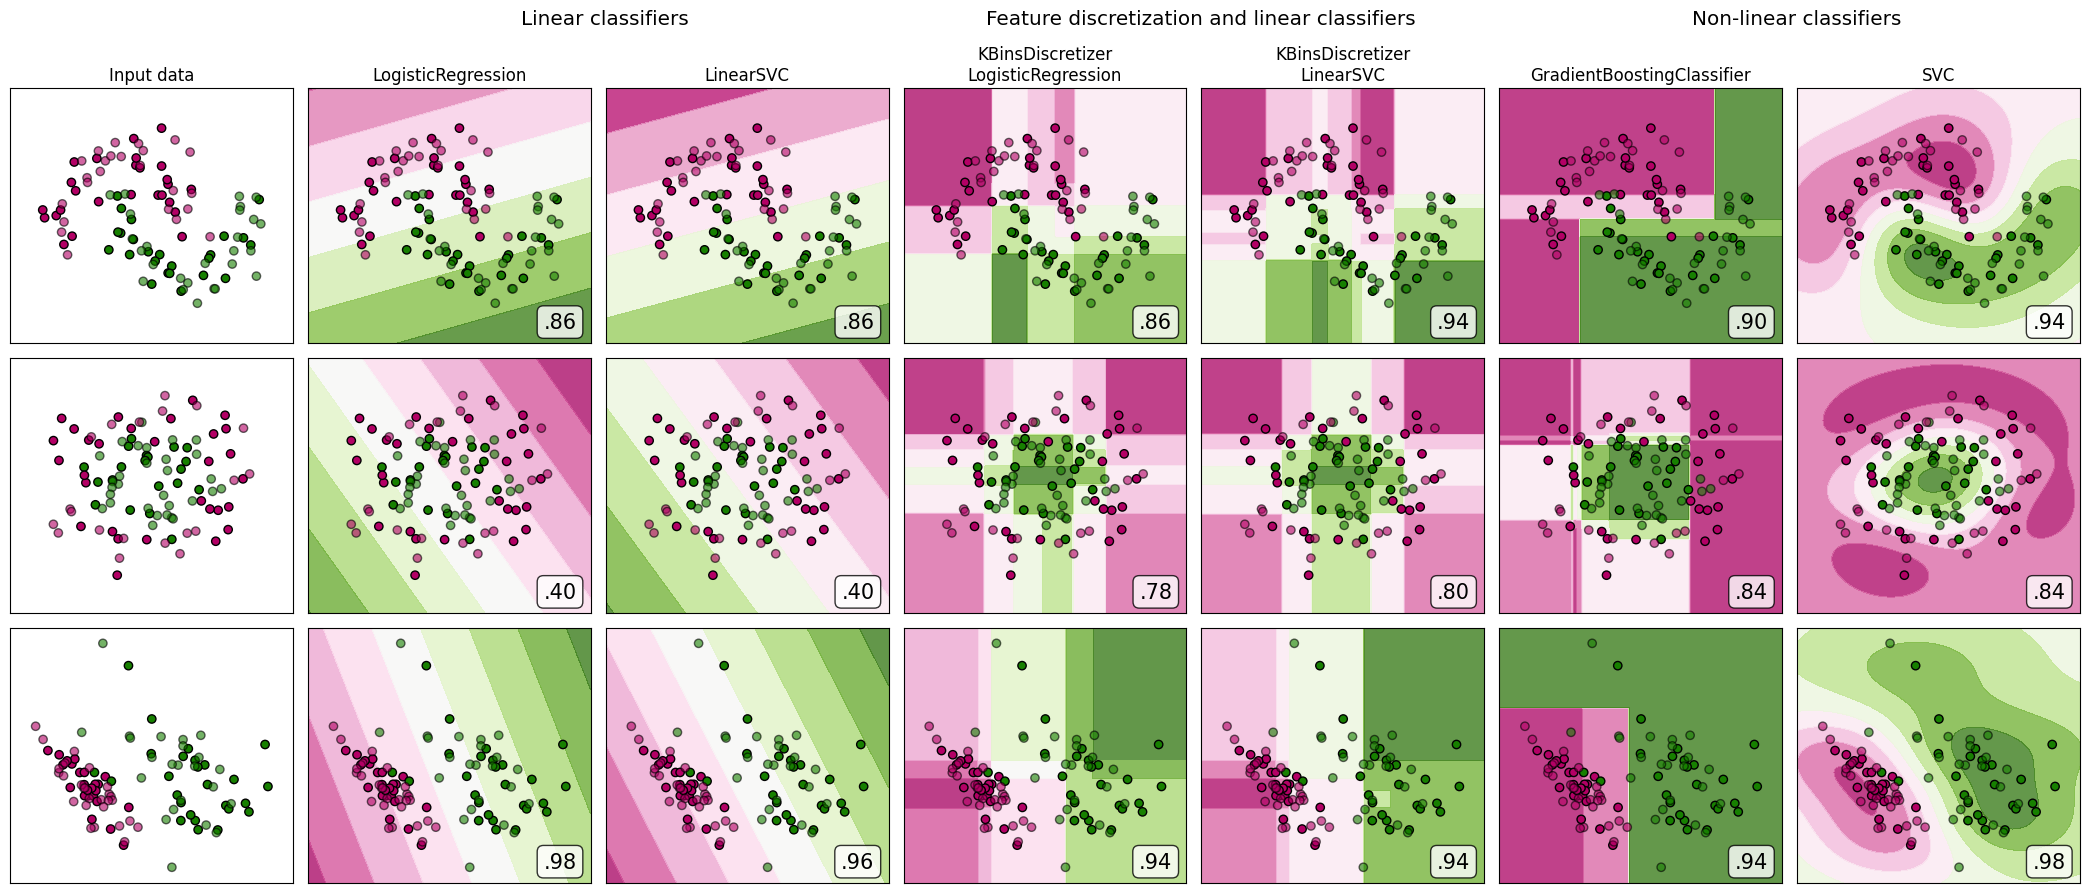

In [1]:
# Code source: Tom Dupré la Tour
# Adapted from plot_classifier_comparison by Gaël Varoquaux and Andreas Müller
#
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.utils._testing import ignore_warnings

h = 0.02  # step size in the mesh


def get_name(estimator):
    name = estimator.__class__.__name__
    if name == "Pipeline":
        name = [get_name(est[1]) for est in estimator.steps]
        name = " + ".join(name)
    return name


# list of (estimator, param_grid), where param_grid is used in GridSearchCV
# The parameter spaces in this example are limited to a narrow band to reduce
# its runtime. In a real use case, a broader search space for the algorithms
# should be used.
classifiers = [
    (
        make_pipeline(StandardScaler(), LogisticRegression(random_state=0)),
        {"logisticregression__C": np.logspace(-1, 1, 3)},
    ),
    (
        make_pipeline(StandardScaler(), LinearSVC(random_state=0, dual="auto")),
        {"linearsvc__C": np.logspace(-1, 1, 3)},
    ),
    (
        make_pipeline(
            StandardScaler(),
            KBinsDiscretizer(encode="onehot"),
            LogisticRegression(random_state=0),
        ),
        {
            "kbinsdiscretizer__n_bins": np.arange(5, 8),
            "logisticregression__C": np.logspace(-1, 1, 3),
        },
    ),
    (
        make_pipeline(
            StandardScaler(),
            KBinsDiscretizer(encode="onehot"),
            LinearSVC(random_state=0, dual="auto"),
        ),
        {
            "kbinsdiscretizer__n_bins": np.arange(5, 8),
            "linearsvc__C": np.logspace(-1, 1, 3),
        },
    ),
    (
        make_pipeline(
            StandardScaler(), GradientBoostingClassifier(n_estimators=5, random_state=0)
        ),
        {"gradientboostingclassifier__learning_rate": np.logspace(-2, 0, 5)},
    ),
    (
        make_pipeline(StandardScaler(), SVC(random_state=0)),
        {"svc__C": np.logspace(-1, 1, 3)},
    ),
]

names = [get_name(e).replace("StandardScaler + ", "") for e, _ in classifiers]

n_samples = 100
datasets = [
    make_moons(n_samples=n_samples, noise=0.2, random_state=0),
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    make_classification(
        n_samples=n_samples,
        n_features=2,
        n_redundant=0,
        n_informative=2,
        random_state=2,
        n_clusters_per_class=1,
    ),
]

fig, axes = plt.subplots(
    nrows=len(datasets), ncols=len(classifiers) + 1, figsize=(21, 9)
)

cm_piyg = plt.cm.PiYG
cm_bright = ListedColormap(["#b30065", "#178000"])

# iterate over datasets
for ds_cnt, (X, y) in enumerate(datasets):
    print(f"\ndataset {ds_cnt}\n---------")

    # split into training and test part
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=42
    )

    # create the grid for background colors
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # plot the dataset first
    ax = axes[ds_cnt, 0]
    if ds_cnt == 0:
        ax.set_title("Input data")
    # plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # and testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

    # iterate over classifiers
    for est_idx, (name, (estimator, param_grid)) in enumerate(zip(names, classifiers)):
        ax = axes[ds_cnt, est_idx + 1]

        clf = GridSearchCV(estimator=estimator, param_grid=param_grid)
        with ignore_warnings(category=ConvergenceWarning):
            clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        print(f"{name}: {score:.2f}")

        # plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]*[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.column_stack([xx.ravel(), yy.ravel()]))
        else:
            Z = clf.predict_proba(np.column_stack([xx.ravel(), yy.ravel()]))[:, 1]

        # put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm_piyg, alpha=0.8)

        # plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # and testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())

        if ds_cnt == 0:
            ax.set_title(name.replace(" + ", "\n"))
        ax.text(
            0.95,
            0.06,
            (f"{score:.2f}").lstrip("0"),
            size=15,
            bbox=dict(boxstyle="round", alpha=0.8, facecolor="white"),
            transform=ax.transAxes,
            horizontalalignment="right",
        )


plt.tight_layout()

# Add suptitles above the figure
plt.subplots_adjust(top=0.90)
suptitles = [
    "Linear classifiers",
    "Feature discretization and linear classifiers",
    "Non-linear classifiers",
]
for i, suptitle in zip([1, 3, 5], suptitles):
    ax = axes[0, i]
    ax.text(
        1.05,
        1.25,
        suptitle,
        transform=ax.transAxes,
        horizontalalignment="center",
        size="x-large",
    )
plt.show()